The Ledoux gradient is:
$$\nabla_{\rm L}=\nabla_{\rm ad}+B\,$$
where the composition term for $N$ species is given by
$$B=-\frac{1}{\chi_T}\sum_{i=1}^{N-1}\left(\frac{\partial\ln P}{\partial\ln X_i}\right)_{\rho,T,{X_{j\neq i}}}\frac{d\ln X_i}{d\ln P} \,.$$
MESA uses the following alternate formulation (Paxton et al. 2013 Equation 8):
$$B=-\frac{1}{\chi_T}\frac{\ln P(\rho_k,T_k,X_{k+1}) - \ln P(\rho_k,T_k,X_k)}{\ln P_{k+1}-\ln P_k}$$
We use the same formula but with a centered difference:
$$B=-\frac{1}{\chi_T}\frac{\ln P(\rho_k,T_k,X_{k+1}) - \ln P(\rho_k,T_k,X_{k-1})}{\ln P_{k+1}-\ln P_{k-1}}$$

Let us test that these give the same answer for a toy model of a 3-component (X,Y,Z) plasma with pressure
$$P=\frac{\rho kT}{\mu m_p}+\frac{1}{3}aT^4$$
$$\mu=(2X+3Y/4+Z/2)^{-1}$$


For the first formulation of B, we can derive these coefficients from the EOS:
$$\chi_X\equiv \left(\frac{\partial\ln P}{\partial\ln X}\right)_{\rho,T,Y,Z}=\frac{X}{P}\frac{2\rho kT}{\mu m_p}$$
$$\chi_Y\equiv \left(\frac{\partial\ln P}{\partial\ln Y}\right)_{\rho,T,X,Z}=\frac{Y}{P}\frac{3\rho kT}{4\mu m_p}$$

In [2]:
# Constants (cgs)
kB = 1.380658e-16
mp = 1.6726e-24
arad = 7.5657e-15

class EOS:
    def update(self,rho,T,X,Y,Z):
        self.rho = rho
        self.T = T
        self.X = X
        self.Y = Y
        self.Z = Z
        self.calc_mu()
        self.calc_P()
        self.calc_chis()
    def calc_mu(self):
        self.mu = 1/(2*self.X + 3*self.Y/4 + self.Z/2)
    def calc_P(self):
        self.P = self.rho*kB*self.T/self.mu/mp + arad*self.T**4/3
    def calc_chis(self):
        self.chi_X = self.X/self.P * 2*self.rho*kB*self.T/(self.mu*mp)
        self.chi_Y = self.Y/self.P * 3*self.rho*kB*self.T/(4*self.mu*mp)

Toy model is a isothermal ($T=10^8$ K) NS ($M=1.4M_\odot$, $R=12$ km) atmosphere, with column depths ranging from $y=10^3$ to $10^{10}$ g/cm $^2$, in HSE ($P=gy$). The composition is pure metals, then pure He, then a solar mix. The transitions in composition are given by sigmoids:
$$f(x) = b + \frac{a-b}{(1+(x/x_0)^\alpha)^\beta}$$
which has $f(0)=a$, $f(\infty)=b$, and some sigmoid-like transition around $x=x_0$. $\alpha$ and $\beta$ control the shape of the transition. 

This crudely mimics a solar-accreting neutron star atmosphere, which has had time to burn all of its hydrogen at depth. The only important ingredient here is the composition gradients.

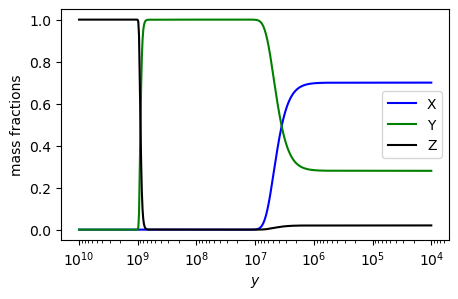

In [1]:
T = 1e8
g = 6.6726e-8*1.4*1.989e33/12e5**2

import numpy as np
lgy = np.linspace(4,10,500)
P = g*10**lgy

# don't want mass fractions of 0 exactly because will use logs later
lo = 1e-10

# X goes from 0.7 to 0 at y=1e7
X = lo+(0.7-lo)/(1+(lgy/7)**50)**10
# Z goes from 0.02 to 0 at y=1e7, the back to 1 at y=1e9
Zbase = 1-3*lo # want both X&Y to =lo at the base
Z = lo+(0.02-lo)/(1+(lgy/7)**50)**10 + Zbase - Zbase/(1+(lgy/9)**500)**10
# Y=1-X-Z
Y = 1-X-Z

# plot
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.gca().invert_xaxis()
plt.semilogx(10**lgy,X,'b-',label='X')
plt.semilogx(10**lgy,Y,'g-',label='Y')
plt.semilogx(10**lgy,Z,'k-',label='Z')
plt.legend()
plt.xlabel(r'$y$')
plt.ylabel(r'mass fractions')
# plt.ylim([-lo,2*lo])
plt.show()

Now solve for density

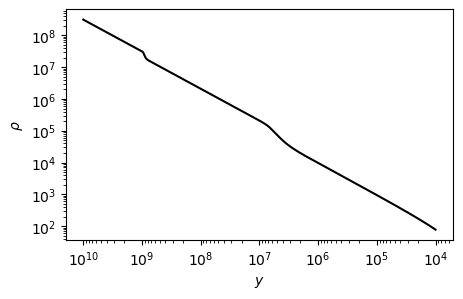

In [3]:
from scipy.optimize import fsolve

rho = []

eos = EOS()
for i,p in enumerate(P):
    def err(rho_try): # what is the error P-P_eos given this trial density
        eos.update(rho_try,T,X[i],Y[i],Z[i])
        return eos.P - p
    
    if i==0:
        rho.append(fsolve(err, x0=1e3)[0])
    else:
        rho.append(fsolve(err, x0=rho[i-1])[0]) # use previous point as guess

plt.figure(figsize=(5,3))
plt.gca().invert_xaxis()
plt.loglog(10**lgy,rho,'k-')
plt.xlabel(r'$y$')
plt.ylabel(r'$\rho$')
plt.show()

Now we can calculate the B's (let's omit $1/\chi_T$ since it's the same in all formulations)

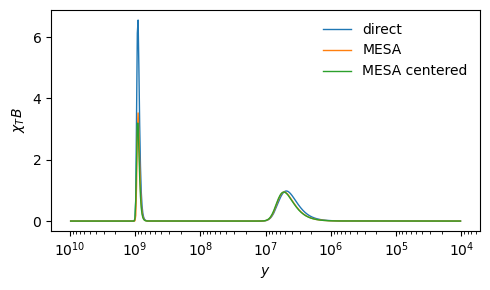

In [4]:
lnP,lnX,lnY = np.log(P),np.log(X),np.log(Y)
B1,B2,B3 = [],[],[]

# skip the first and last point because we do centered diffs
for i in range(1,len(P)-1):
    eos.update(rho[i],T,X[i],Y[i],Z[i])
    chi_X, chi_Y = eos.chi_X, eos.chi_Y

    dlnX_dlnP = (lnX[i+1]-lnX[i-1])/(lnP[i+1]-lnP[i-1])
    dlnY_dlnP = (lnY[i+1]-lnY[i-1])/(lnP[i+1]-lnP[i-1])

    B1.append(-chi_X*dlnX_dlnP - chi_Y*dlnY_dlnP)

    # eval the presusre here(i) but with the composition above/below
    eos.update(rho[i],T,X[i+1],Y[i+1],Z[i+1])
    lnPalt_above = np.log(eos.P)

    eos.update(rho[i],T,X[i-1],Y[i-1],Z[i-1])
    lnPalt_below = np.log(eos.P)

    B2.append(-(lnPalt_above - lnP[i]) / (lnP[i+1]-lnP[i]))
    B3.append(-(lnPalt_above - lnPalt_below) / (lnP[i+1]-lnP[i-1]))

plt.figure(figsize=(5,3))
plt.gca().invert_xaxis()
plt.semilogx(10**lgy[1:-1], B1, lw=1, label="direct")
plt.semilogx(10**lgy[1:-1], B2, lw=1, label="MESA")
plt.semilogx(10**lgy[1:-1], B3, lw=1, label="MESA centered")
plt.legend(frameon=False)
plt.xlabel(r'$y$')
plt.ylabel(r'$\chi_T B$')
plt.tight_layout()
plt.show()

All agree, except at the sharpest composition jumps, where the MESA method smooths out the peak.